# Import libraries

In [1]:
!gdown 1wexRlCyG9_xAqvzSXq0JlPxmrcqm5QC7

Downloading...
From (original): https://drive.google.com/uc?id=1wexRlCyG9_xAqvzSXq0JlPxmrcqm5QC7
From (redirected): https://drive.google.com/uc?id=1wexRlCyG9_xAqvzSXq0JlPxmrcqm5QC7&confirm=t&uuid=5e0144a1-5c51-450c-89f4-3da00a00ea27
To: /content/images.zip
100% 130M/130M [00:05<00:00, 23.3MB/s]


In [2]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/scene_001_end.jpg  
  inflating: images/scene_001_mid.jpg  
  inflating: images/scene_001_start.jpg  
  inflating: images/scene_002_end.jpg  
  inflating: images/scene_002_mid.jpg  
  inflating: images/scene_002_start.jpg  
  inflating: images/scene_003_end.jpg  
  inflating: images/scene_003_mid.jpg  
  inflating: images/scene_003_start.jpg  
  inflating: images/scene_004_end.jpg  
  inflating: images/scene_004_mid.jpg  
  inflating: images/scene_004_start.jpg  
  inflating: images/scene_005_end.jpg  
  inflating: images/scene_005_mid.jpg  
  inflating: images/scene_005_start.jpg  
  inflating: images/scene_006_end.jpg  
  inflating: images/scene_006_mid.jpg  
  inflating: images/scene_006_start.jpg  
  inflating: images/scene_007_end.jpg  
  inflating: images/scene_007_mid.jpg  
  inflating: images/scene_007_start.jpg  
  inflating: images/scene_008_end.jpg  
  inflating: images/scene_008_mid.jpg  
  inflating: images/scen

In [3]:
!nvidia-smi

Sun Aug 24 15:23:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q ultralytics
!pip install -q faiss-cpu
!pip install -q googletrans
!pip install -q nest_asyncio

  Preparing metadata (setup.py) ... done


In [7]:
import os
import torch
import clip
from PIL import Image
from IPython.display import display
import faiss
import numpy as np
import json
import glob
import numpy as np
from ultralytics import YOLO
from transformers import pipeline
import re
import googletrans
from collections import defaultdict

# tiny & nhanh nhất; nếu GPU khỏe có thể dùng yolov8s.pt
yolo = YOLO('yolov8n.pt')
device = "cuda" if torch.cuda.is_available() else "cpu"
yolo.to(0 if device == "cuda" else "cpu")

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

# Initialize model

In [21]:
model, preprocess = clip.load("ViT-B/32", device=device)

# BLIP captioner (mặc định tiếng Anh)
captioner = pipeline(
    task="image-to-text",
    model="Salesforce/blip-image-captioning-base",
    device=0 if device=="cuda" else -1
)

# Dịch VI -> EN
from googletrans import Translator
translator = Translator()

import nest_asyncio, asyncio
nest_asyncio.apply()

async def _vi_to_en_async(text_vi: str) -> str:
    res = await translator.translate(text_vi, src='vi', dest='en')
    return res.text

def vi_to_en(text_vi: str) -> str:
    try:
        loop = asyncio.get_event_loop()
        return loop.run_until_complete(_vi_to_en_async(text_vi))
    except Exception:
        # fallback khi dịch lỗi: dùng nguyên bản
        return text_vi

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2199: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Device set to use cuda:0


In [9]:
def detect_labels(image_path, conf=0.25, iou=0.65, max_det=20, max_labels=12):
    # chạy YOLO
    r = yolo.predict(
        image_path, conf=conf, iou=iou, max_det=max_det,
        device=0 if device=="cuda" else "cpu", verbose=False
    )[0]
    names = r.names  # dict: id -> name
    cls_ids = r.boxes.cls.detach().cpu().numpy().astype(int) if r.boxes is not None else []
    labels = [names[i] for i in cls_ids] if len(cls_ids) else []
    # lọc trùng và giữ tối đa max_labels
    uniq = []
    for lb in labels:
        if lb not in uniq:
            uniq.append(lb)
        if len(uniq) >= max_labels:
            break
    return uniq

def clip_text_embed_list(labels, device="cuda"):
    """
    Encode danh sách labels bằng CLIP text:
    mean-pool các vector của "a photo of a {label}".
    """
    if not labels:
        # fallback: vector zero (trả None để bỏ qua)
        return None
    phrases = [f"a photo of a {re.sub(r'[_]+',' ',lb)}" for lb in labels]
    tokens = clip.tokenize(phrases, truncate=True).to(device)
    with torch.no_grad():
        embs = model.encode_text(tokens)         # (m, 512)
    embs = embs / embs.norm(dim=-1, keepdim=True)
    vec = embs.mean(dim=0, keepdim=True)        # (1, 512)
    vec = vec / vec.norm(dim=-1, keepdim=True)
    return vec  # torch tensor (1,512)

In [11]:
def clip_text_embed(text: str, device="cpu"):
    # lọc spam ngoặc/ khoảng trắng thừa
    text = re.sub(r'[\[\]]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenize với truncate=True để tự cắt còn 77 tokens
    tokens = clip.tokenize([text], truncate=True).to(device)
    with torch.no_grad():
        v = model.encode_text(tokens)
    v = v / v.norm(dim=-1, keepdim=True)     # L2-normalize (cosine-ready)
    return v

# Build embeddings

In [12]:
id2img_fps = {}
id2caption = {}
id2objects = {}
img_vecs, cap_vecs, obj_vecs, hybrid_vecs = [], [], [], []

list_image = []
for ext in ("*.jpg","*.jpeg","*.png","*.webp"):
    list_image += glob.glob(os.path.join("images", ext))

# trọng số cho early-fusion 3 thành phần
W_IMG, W_CAP, W_OBJ = 0.45, 0.35, 0.20  # bạn có thể đổi

for idx, image_path in enumerate(sorted(list_image)):
    id2img_fps[idx] = image_path

    # ---- 1) Ảnh -> CLIP image embedding (cosine-ready)
    img = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        iv = model.encode_image(img)                         # (1,512)
    iv = iv / iv.norm(dim=-1, keepdim=True)                 # L2-normalize
    img_vecs.append(iv.cpu().numpy().astype("float32"))     # (1,512)

    # ---- 2) Ảnh -> BLIP caption (EN)
    cap = captioner(image_path, max_new_tokens=30)[0]["generated_text"]
    id2caption[idx] = cap

    # ---- 2.5) Object labels & embedding
    labels = detect_labels(image_path)
    id2objects[idx] = labels
    ov = clip_text_embed_list(labels, device=device)  # (1,512) hoặc None

    if ov is None:
        # nếu không có object, dùng vector 0 ảnh hưởng tối thiểu
        ov = torch.zeros_like(iv)

    obj_vecs.append(ov.cpu().numpy().astype("float32"))

    # ---- 3) Caption -> CLIP text embedding (cosine-ready)
    try:
        tv = clip_text_embed(cap, device=device)                  # (1,512) torch tensor
    except RuntimeError as e:
        # fallback an toàn nếu vẫn quá dài/ lỗi lạ: cắt theo từ rồi encode
        cap_short = ' '.join(cap.split()[:60])
        tv = clip_text_embed(cap_short, device=device)
    cap_vecs.append(tv.cpu().numpy().astype("float32"))           # (1,512)

    # ---- 4) Hybrid (trộn ảnh + caption trong cùng không gian CLIP)
    hv = torch.nn.functional.normalize(W_IMG*iv + W_CAP*tv + W_OBJ*ov, dim=-1)
    hybrid_vecs.append(hv.cpu().numpy().astype("float32"))

image_embeddings  = np.vstack(img_vecs).astype("float32")     # (N,512)
caption_embeddings = np.vstack(cap_vecs).astype("float32")    # (N,512)
object_embeddings = np.vstack(obj_vecs).astype("float32")      # (N,512)
hybrid_embeddings  = np.vstack(hybrid_vecs).astype("float32") # (N,512)

# Lưu mapping
with open('image_path.json', 'w', encoding='utf-8') as f:
    json.dump(id2img_fps, f, ensure_ascii=False, indent=2)
with open('captions.json', 'w', encoding='utf-8') as f:
    json.dump(id2caption, f, ensure_ascii=False, indent=2)
with open('objects.json', 'w', encoding='utf-8') as f:
    json.dump(id2objects, f, ensure_ascii=False, indent=2)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Crate FAISS index (cosine = inner product in normalized vector)

In [13]:
d = image_embeddings.shape[1]  # 512

# 1) Index ảnh
index_img = faiss.IndexFlatIP(d)
faiss.normalize_L2(image_embeddings)   # an toàn nếu đã norm trước
index_img.add(image_embeddings)
faiss.write_index(index_img, 'faiss_img_ViT.bin')

# 2) Index caption (text embedding)
index_cap = faiss.IndexFlatIP(d)
faiss.normalize_L2(caption_embeddings)
index_cap.add(caption_embeddings)
faiss.write_index(index_cap, 'faiss_cap_ViT.bin')

# 3) Index object
index_obj = faiss.IndexFlatIP(d)
faiss.normalize_L2(object_embeddings)
index_obj.add(object_embeddings)
faiss.write_index(index_obj, 'faiss_obj_CLIP.bin')

# 4) Index hybrid (ảnh+caption)
index_hybrid = faiss.IndexFlatIP(d)
faiss.normalize_L2(hybrid_embeddings)
index_hybrid.add(hybrid_embeddings)
faiss.write_index(index_hybrid, 'faiss_hybrid_ViT_BLIP.bin')

# Query and find top-k

In [14]:
def _encode_query_en(query_en: str) -> np.ndarray:
    tokens = clip.tokenize([query_en]).to(device)
    with torch.no_grad():
        q = model.encode_text(tokens)
    q = q / q.norm(dim=-1, keepdim=True)
    return q.cpu().numpy().astype("float32")

def search(query_vi: str, k: int=5, mode: str="fuse",
           alpha_img=0.4, alpha_cap=0.4, alpha_obj=0.2,
           k_img: int=50, k_cap: int=50, k_obj: int=50, fuse_method="sum"):
    query_en = vi_to_en(query_vi)
    qv = _encode_query_en(query_en)

    if mode == "obj":
        D,I = index_obj.search(qv, k)
        ids, scores = I[0], D[0]

    elif mode == "hybrid":
        D,I = index_hybrid.search(qv, k)
        ids, scores = I[0], D[0]

    elif mode == "fuse":
        # lấy kết quả từ 3 index
        D1,I1 = index_img.search(qv, k_img)
        D2,I2 = index_cap.search(qv, k_cap)
        D3,I3 = index_obj.search(qv, k_obj)

        if fuse_method == "sum":
            # weighted-sum trên cosine (cùng thang)
            agg = defaultdict(float)
            for i,s in zip(I1[0], D1[0]): agg[int(i)] += alpha_img * float(s)
            for i,s in zip(I2[0], D2[0]): agg[int(i)] += alpha_cap * float(s)
            for i,s in zip(I3[0], D3[0]): agg[int(i)] += alpha_obj * float(s)
            ranked = sorted(agg.items(), key=lambda x: x[1], reverse=True)[:k]
            ids, scores = zip(*ranked) if ranked else ([],[])
        elif fuse_method == "rrf":
            # RRF gộp theo rank (không phụ thuộc điểm)
            def rrf_fuse(rank_lists, K=60, topk=5, weights=None):
                from collections import defaultdict
                if weights is None: weights = [1.0]*len(rank_lists)
                sc = defaultdict(float)
                for w, rl in zip(weights, rank_lists):
                    for r, _id in enumerate(rl, start=1):
                        sc[int(_id)] += w * (1.0/(K+r))
                out = sorted(sc.items(), key=lambda x: x[1], reverse=True)
                return out[:topk]
            ranked = rrf_fuse([I1[0].tolist(), I2[0].tolist(), I3[0].tolist()],
                              K=60, topk=k, weights=[alpha_img, alpha_cap, alpha_obj])
            ids, scores = zip(*ranked) if ranked else ([],[])
        else:
            raise ValueError("fuse_method phải là 'sum' hoặc 'rrf'")
    else:
        raise ValueError("mode phải là 'obj' | 'hybrid3' | 'fuse'")

    results = [{
        "id": int(i),
        "score": float(s),
        "path": id2img_fps[int(i)],
        "caption": id2caption.get(int(i), ""),
        "objects": id2objects.get(int(i), [])
    } for i,s in zip(ids, scores)]
    return query_en, results

# Test

score: 0.0622
caption: a man is riding a motorcycle down the road
objects: ['person', 'motorcycle', 'kite']


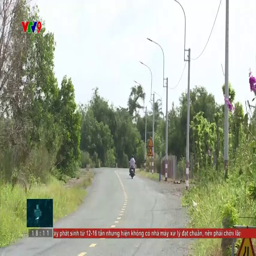

score: 0.0582
caption: a street with cars and motorcycles on it
objects: ['motorcycle', 'person', 'bicycle', 'truck']


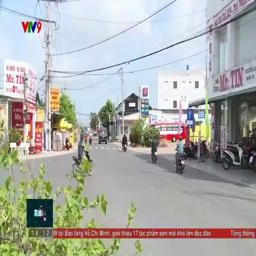

score: 0.0539
caption: a street scene with a man riding a motorcycle
objects: ['motorcycle', 'person', 'bicycle', 'car']


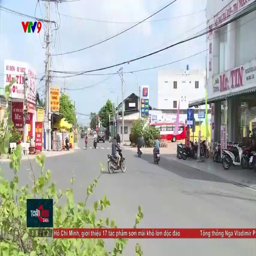

score: 0.0532
caption: a man riding a bike down a street
objects: ['motorcycle']


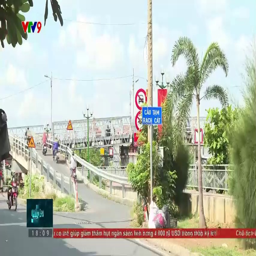

score: 0.0463
caption: a man riding a bike down a street
objects: ['person', 'bicycle']


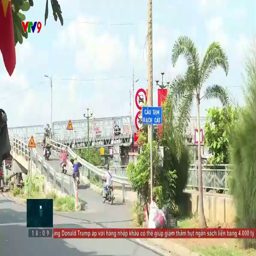

score: 0.0385
caption: a man riding a motorcycle through a flooded street
objects: ['motorcycle', 'person']


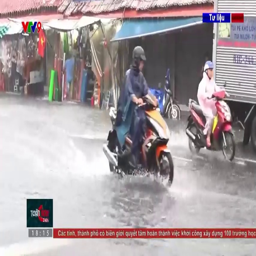

score: 0.0384
caption: a factory with a man working on machinery
objects: ['person', 'car']


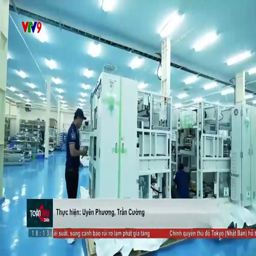

score: 0.0374
caption: a factory with a man working on a machine
objects: ['person', 'car']


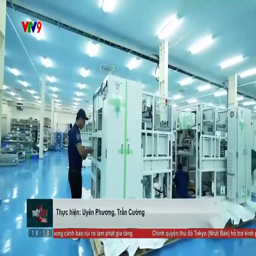

score: 0.0370
caption: a street with many shops and stores
objects: ['person', 'bicycle', 'motorcycle']


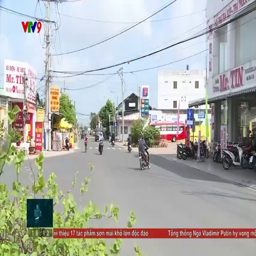

In [46]:
query_en, hits = search("xe máy", k=9, mode="fuse",
                        alpha_img=1, alpha_cap=2, alpha_obj=1.5,
                        fuse_method="rrf")
for r in hits:
    print(f"score: {r['score']:.4f}")
    print(f"caption: {r['caption']}")
    print(f"objects: {r['objects']}")
    display(Image.open(r['path']).resize((256, 256)))